In [2]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as clr
from matplotlib.colorbar import ColorbarBase
# from matplotlib import gridspec

In [3]:
# data_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/datasets/PCLsubscales_selfreportZ_roberta_laL23rpca64_wtcSubscalesNormalized_merged_PCL_1_days_ahead_reset_time2zero_max90days_v6_60combined_5fold_oots"
data_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/datasets/PCLsubscales_selfreportZ_roberta_laL23rpca64_wtcSubscalesNormalized_merged_PCL_1_days_ahead_reset_time2zero2_max90days_v6_60combined_5fold_oots"
dataDict = load_from_disk(data_path)
dataDict

Dataset({
    features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'embeddings_wtcSubscales', 'mask_wtcSubscales', 'outcomes', 'outcomes_mask', 'orig_time_ids', 'folds', 'oots_mask', 'embeddings_subscales_z'],
    num_rows: 196
})

## Timeline Plot

In [3]:
num_subscales_days = [(90 - sum(i)) for i in dataDict['mask_subscales']]
num_lang_days = [(90 - sum(i)) for i in dataDict['mask_lang']]
num_outcomes_days = [np.array(i).sum() for i in dataDict['outcomes_mask']]

In [4]:
np.corrcoef(num_subscales_days, num_lang_days)

array([[1.        , 0.82253369],
       [0.82253369, 1.        ]])

In [5]:
print (np.corrcoef(num_subscales_days, num_outcomes_days))

[[1.         0.99387927]
 [0.99387927 1.        ]]


In [6]:
print (np.corrcoef(num_lang_days, num_outcomes_days))

[[1.         0.82612725]
 [0.82612725 1.        ]]


In [7]:
max_subscale_days, max_lang_days = max(num_subscales_days), max(num_lang_days)
max_days = max(max_subscale_days, max_lang_days)
print ("Max days (subscales, lang, both): ", max_subscale_days, max_lang_days, max_days)

min_subscale_days, min_lang_days = min(num_subscales_days), min(num_lang_days)
min_days = min(min_subscale_days, min_lang_days)
print ("Min days (subscales, lang, both): ", min_subscale_days, min_lang_days, min_days)

Max days (subscales, lang, both):  90 90 90
Min days (subscales, lang, both):  48 33 33


In [8]:
subscale_days = []
lang_days = []
outcomes_days = []
for i in range(len(dataDict['mask_subscales'])):
    subscale_days.append(dataDict['mask_subscales'][i] + [1]*(max_days - len(dataDict['mask_subscales'][i])))
    lang_days.append(dataDict['mask_lang'][i] + [1]*(max_days - (len(dataDict['mask_lang'][i]))))
    outcomes_days.append(np.array(dataDict['outcomes_mask'][i]).reshape(-1, ).tolist() + [0]*(max_days - len(dataDict['outcomes_mask'][i])))

subscale_days = (~np.array(subscale_days, dtype=bool)).astype(int)
lang_days = (~np.array(lang_days, dtype=bool)).astype(int)
outcomes_days = np.array(outcomes_days).astype(int)

print (subscale_days.shape, lang_days.shape, outcomes_days.shape)

(196, 90) (196, 90) (196, 90)


In [9]:
def combine_masks(mask1, mask2):
    combined_masks = []
    assert len(mask1) == len(mask2), "Length of the masks should be the same. Mask 1 length: {}, Mask 2 length: {}".format(len(mask1), len(mask2))
    for i in range(len(mask1)):
        seq_mask = []
        for j in range(len(mask1[i])):
            if mask1[i][j] == 0 and mask2[i][j] == 0:
                seq_mask.append(0)
            elif mask1[i][j] != 0 and mask2[i][j] != 0:
                seq_mask.append(3)
            elif mask1[i][j] != 0 and mask2[i][j] == 0:
                seq_mask.append(1)
            elif mask1[i][j] == 0 and mask2[i][j] != 0:
                seq_mask.append(2)
        combined_masks.append(seq_mask)
    return combined_masks

combined_langSubscales_mask = combine_masks(lang_days, subscale_days)
combined_langOutcomes_mask = combine_masks(lang_days, outcomes_days)
combined_subscalesOutcomes_mask = combine_masks(subscale_days, outcomes_days)
combined_langSubscalesOutcomes_mask = combine_masks(combined_langSubscales_mask, outcomes_days)


In [10]:
sorted_idxs = np.argsort(num_subscales_days)
combined_langSubscalesOutcomes_mask_sorted = np.array(combined_langSubscalesOutcomes_mask)[sorted_idxs][::-1]

In [11]:
clrs = list(map(lambda x: (x[0]/8.0, x[1]), enumerate(['#d73027','#f46d43','#fdae61','#fee08b','#ffffbf','#d9ef8b','#a6d96a','#66bd63','#1a9850'])))
custom_cmap = clr.LinearSegmentedColormap.from_list('custom coolwarm', clrs, N=512)

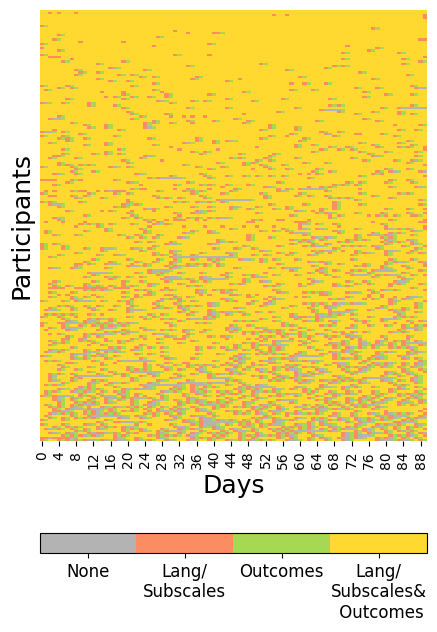

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
# Plot the combined mask on a heatmap
set2_colors = sns.color_palette("Set2").as_hex()
# Choose only 4 colors from the tab20 palette
colors4 = [set2_colors[i] for i in [7, 1, 4, 5]]
custom_cmap = clr.ListedColormap(colors4)
sns.heatmap(combined_langSubscalesOutcomes_mask_sorted, ax=ax, cmap=custom_cmap, cbar=False)
ax.set_yticks([])
# Set the cbar tocks as ['None', 'Outcomes', 'Language/Subscales', 'Outcomes & Language/Subscales']
my_cmap = clr.ListedColormap(colors4)
norm = clr.Normalize(vmin=0, vmax=3)
sm = ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_ticks([0.75/2, (1.5+0.75)/2, (1.5+2.25)/2, (5.25)/2])
cbar.set_ticklabels(['None', 'Lang/\nSubscales', 'Outcomes', 'Lang/\nSubscales&\n Outcomes'], fontsize=12)

# Set the x and y labels
ax.set_xlabel('Days', fontsize=18)
ax.set_ylabel('Participants', fontsize=18)

plt.show()

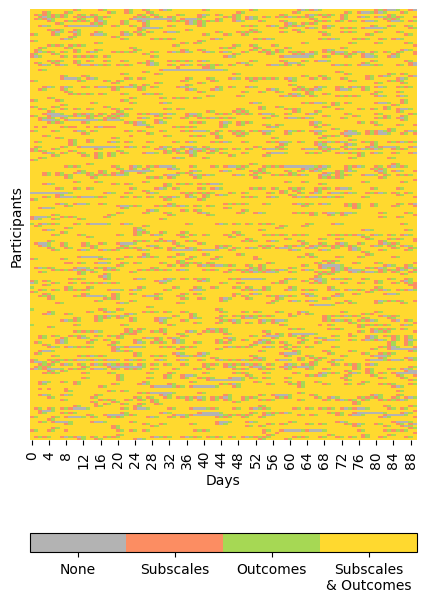

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
# Plot the combined mask on a heatmap
set2_colors = sns.color_palette("Set2").as_hex()
# Choose only 4 colors from the tab20 palette
colors4 = [set2_colors[i] for i in [7, 1, 4, 5]]
custom_cmap = clr.ListedColormap(colors4)
sns.heatmap(combined_subscalesOutcomes_mask, ax=ax, cmap=custom_cmap, cbar=False)
ax.set_yticks([])

# Set the cbar tocks as ['None', 'Outcomes', 'Language/Subscales', 'Outcomes & Language/Subscales']
my_cmap = clr.ListedColormap(colors4)
norm = clr.Normalize(vmin=0, vmax=3)
sm = ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_ticks([0.75/2, (1.5+0.75)/2, (1.5+2.25)/2, (5.25)/2])
cbar.set_ticklabels(['None', 'Subscales', 'Outcomes', 'Subscales\n& Outcomes'])

# Set the x and y labels
ax.set_xlabel('Days')
ax.set_ylabel('Participants')
plt.show()

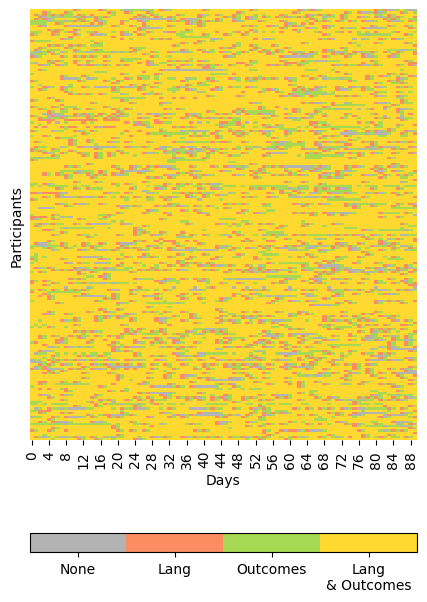

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
# Plot the combined mask on a heatmap
set2_colors = sns.color_palette("Set2").as_hex()
# Choose only 4 colors from the tab20 palette
colors4 = [set2_colors[i] for i in [7, 1, 4, 5]]
custom_cmap = clr.ListedColormap(colors4)
sns.heatmap(combined_langOutcomes_mask, ax=ax, cmap=custom_cmap, cbar=False)
ax.set_yticks([])

# Set the cbar tocks as ['None', 'Outcomes', 'Language/Subscales', 'Outcomes & Language/Subscales']
my_cmap = clr.ListedColormap(colors4)
norm = clr.Normalize(vmin=0, vmax=3)
sm = ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_ticks([0.75/2, (1.5+0.75)/2, (1.5+2.25)/2, (5.25)/2])
cbar.set_ticklabels(['None', 'Lang', 'Outcomes', 'Lang\n& Outcomes'])

# Set the x and y labels
ax.set_xlabel('Days')
ax.set_ylabel('Participants')
plt.show()

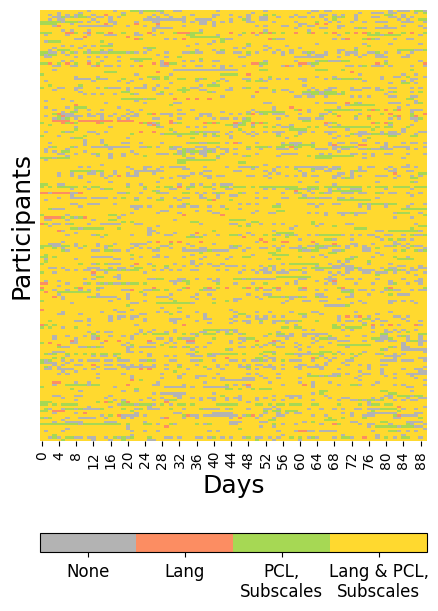

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
# Plot the combined mask on a heatmap
set2_colors = sns.color_palette("Set2").as_hex()
# Choose only 4 colors from the tab20 palette
colors4 = [set2_colors[i] for i in [7, 1, 4, 5]]
custom_cmap = clr.ListedColormap(colors4)
sns.heatmap(combined_langSubscales_mask, ax=ax, cmap=custom_cmap, cbar=False)
ax.set_yticks([])

# Set the cbar tocks as ['None', 'Outcomes', 'Language/Subscales', 'Outcomes & Language/Subscales']
my_cmap = clr.ListedColormap(colors4)
norm = clr.Normalize(vmin=0, vmax=3)
sm = ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_ticks([0.75/2, (1.5+0.75)/2, (1.5+2.25)/2, (5.25)/2])
cbar.set_ticklabels(['None', 'Lang', 'PCL,\nSubscales', 'Lang & PCL,\nSubscales'], fontsize=12)

# Set the x and y labels
ax.set_xlabel('Days', fontsize=18)
ax.set_ylabel('Participants', fontsize=18)
plt.show()

## Data Statistics

In [16]:
# Collect 
# 1. Number of sequences
# 2. Mean and median Number of days with language 
# 3. Mean and median Number of days with subscales
# 4. Mean and median Number of days with outcomes
# 5. Cumulative distribution of the number of days with lang/subscales and outcomes

In [17]:
print ("Number of sequences: ", len(dataDict['mask_subscales']))
print ("Min and Max number of days with language: ", min(num_lang_days), max(num_lang_days))
print ("Mean and median Number of days with language: ", np.mean(num_lang_days), np.median(num_lang_days))
print ("Min and Max number of days with subscales: ", min(num_subscales_days), max(num_subscales_days))
print ("Mean and median Number of days with subscales: ", np.mean(num_subscales_days), np.median(num_subscales_days))
print ("Min and Max number of days with outcomes: ", min(num_outcomes_days), max(num_outcomes_days))
print ("Mean and median Number of days with outcomes: ", np.mean(num_outcomes_days), np.median(num_outcomes_days))

Number of sequences:  196
Min and Max number of days with language:  33 90
Mean and median Number of days with language:  70.63775510204081 73.0
Min and Max number of days with subscales:  48 90
Mean and median Number of days with subscales:  75.52551020408163 77.0
Min and Max number of days with outcomes:  48 90
Mean and median Number of days with outcomes:  75.11734693877551 76.0


In [18]:
# Print total number of language days, subscales days and outcomes days
print ("Total number of language days: ", sum(num_lang_days))
print ("Total number of subscales days: ", sum(num_subscales_days))
print ("Total number of outcomes days: ", sum(num_outcomes_days))

Total number of language days:  13845
Total number of subscales days:  14803
Total number of outcomes days:  14723


In [19]:
dataDict

Dataset({
    features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'embeddings_wtcSubscales', 'mask_wtcSubscales', 'outcomes', 'outcomes_mask', 'orig_time_ids', 'folds', 'oots_mask', 'embeddings_subscales_z'],
    num_rows: 196
})

In [20]:
dataDict.filter(lambda x: x['folds'] != 4 and x['folds'] != 0)

Filter:   0%|          | 0/196 [00:00<?, ? examples/s]

Dataset({
    features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'embeddings_wtcSubscales', 'mask_wtcSubscales', 'outcomes', 'outcomes_mask', 'orig_time_ids', 'folds', 'oots_mask', 'embeddings_subscales_z'],
    num_rows: 117
})

## Time Series Plot

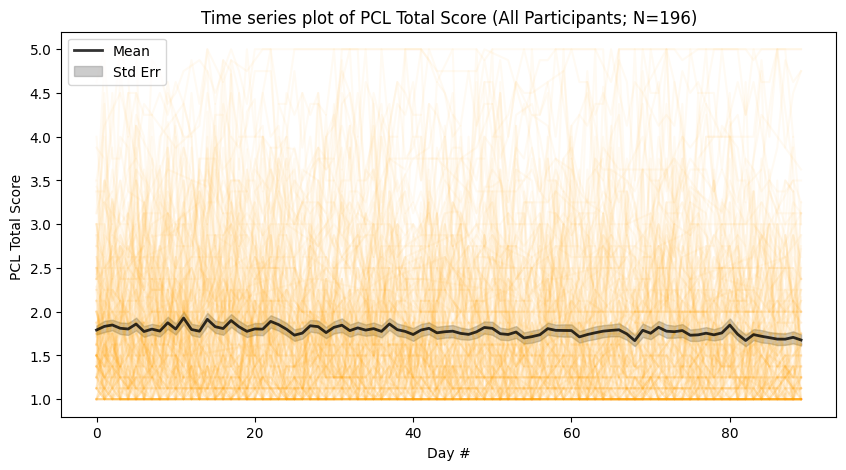

In [23]:
# Need to plot the time series of all participants in the same graph as a line plot with light opacity (same color). 
# Then plot the mean and std err of the time series in a bolder color in the same graph.
# Only consider valid days for each participant.
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

subscales, mask, time_ids = [], [], []
for i in range(len(dataDict['mask_subscales'])):
    temp_y = np.array(dataDict['embeddings_subscales'][i])[:, 0]
    temp_mask = (np.array(dataDict['mask_subscales'][i]) == 0) & (temp_y != 0) 
    temp_x = np.array(dataDict['time_ids'][i])
    ax.plot(temp_x[temp_mask==1], temp_y[temp_mask==1], color='orange', alpha=0.05)
    temp_y = np.array(temp_y.tolist() + [0]*(max_days - len(dataDict['embeddings_subscales'][i])))
    temp_mask = np.array(temp_mask.tolist() + [0]*(max_days - len(dataDict['mask_subscales'][i])))
    subscales.append(temp_y)
    mask.append(temp_mask)

# Compute the mean and the std err for each axis only for mask == 0
subscales = np.array(subscales)
mask = np.array(mask)
# Create a boolean array that is True for valid entries (mask==0)
valid = (mask == 1)
# Compute the mean for each subscale (each column) using only valid entries.
# For each column, sum the valid subscale values and divide by the count of valid entries.
mean_subscales = np.sum(np.where(valid, subscales, 0), axis=0) / np.sum(valid, axis=0)

# Now compute the standard error.
# First, compute the variance only on valid entries.
# We subtract the mean (which will broadcast along the rows) from each entry,
# square the difference, mask out invalid entries, sum along axis 0, and then divide by (n_valid-1).
n_valid = np.sum(valid, axis=0)  # count of valid entries per subscale
# Use ddof=1 for an unbiased estimator of the variance.
variance = np.sum(np.where(valid, (subscales - mean_subscales) ** 2, 0), axis=0) / (n_valid - 1)
std_subscales = np.sqrt(variance)

# Finally, the standard error is the standard deviation divided by the square root
# of the number of valid entries.
stderr_subscales = std_subscales / np.sqrt(n_valid)

ax.plot(range(90), mean_subscales, color='black', label='Mean', linewidth=2, alpha=0.8)
ax.fill_between(range(90), mean_subscales - stderr_subscales, mean_subscales + stderr_subscales, color='gray', alpha=0.4, label='Std Err')
ax.set_xlabel('Day #')
ax.set_ylabel('PCL Total Score ')
plt.title('Time series plot of PCL Total Score (All Participants; N=196)')
plt.legend()
plt.show()

In [112]:
y.shape

(90,)

In [128]:
# Fit a linear model on mean_subscales using time_ids as input and report the \Beta and p-value

from sklearn.linear_model import LinearRegression
from scipy.stats import t
import statsmodels.api as sm

X = np.arange(90).reshape(-1, 1)
y = mean_subscales
X = (X - np.mean(X))/np.std(X)
reg = LinearRegression().fit(X, y)
print ("Beta: ", reg.coef_)
print ("Intercept: ", reg.intercept_)
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


Beta:  [-0.03354436]
Intercept:  1.781683058530232
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     62.50
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           7.22e-12
Time:                        08:55:02   Log-Likelihood:                 162.44
No. Observations:                  90   AIC:                            -320.9
Df Residuals:                      88   BIC:                            -315.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

In [127]:
np.corrcoef(X[:, 1], y)

array([[ 1.       , -0.6444228],
       [-0.6444228,  1.       ]])

In [108]:
valid.sum(0)

array([188, 171, 174, 162, 160, 157, 165, 172, 157, 162, 172, 156, 160,
       164, 164, 164, 157, 169, 162, 172, 158, 163, 162, 167, 167, 164,
       161, 162, 167, 165, 165, 163, 160, 162, 171, 164, 160, 163, 159,
       166, 155, 165, 170, 168, 161, 166, 169, 170, 164, 172, 165, 170,
       159, 173, 162, 164, 162, 171, 173, 163, 158, 162, 166, 159, 164,
       164, 158, 162, 159, 154, 168, 165, 159, 168, 159, 163, 167, 169,
       165, 164, 160, 155, 155, 170, 160, 161, 157, 159, 158, 165])

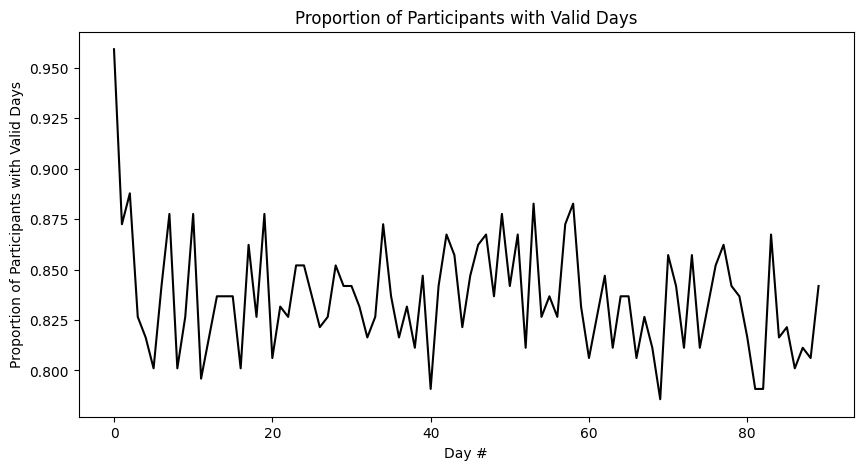

In [24]:
## Plot the number of valid days on y axis and day # on x axis. Normalize the number of valid days by the total number of participants.
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Plot the number of valid days for each day
valid_days = valid.mean(0)
ax.plot(valid_days, color='black', label='Valid Days')
ax.set_xlabel('Day #')
ax.set_ylabel('Proportion of Participants with Valid Days')
plt.title('Proportion of Participants with Valid Days')
# plt.legend()
plt.show()


In [26]:
dataDict

Dataset({
    features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'embeddings_wtcSubscales', 'mask_wtcSubscales', 'outcomes', 'outcomes_mask', 'orig_time_ids', 'folds', 'oots_mask', 'embeddings_subscales_z'],
    num_rows: 196
})

In [17]:
# Sample seq_ids with replacement
NUM_TRIALS = 20
WINDOW_SIZE=30
OVERLAP=15
NUM_OUTCOMES=1
FULL_LEGNTH=90
BLOCK_MEANS = []
for trial in range(NUM_TRIALS):
    idxs = np.random.choice(len(dataDict['seq_id']), (len(dataDict), ), replace=True)
    outcomes = []
    outcomes_mask = []
    for idx in idxs:
        if len(dataDict['outcomes'][idx]) < FULL_LEGNTH:
            remainder = FULL_LEGNTH - len(dataDict['outcomes'][idx])
            outcomes.append(dataDict['outcomes'][idx] + [[0]*NUM_OUTCOMES]*remainder)
            outcomes_mask.append(dataDict['outcomes_mask'][idx] + [[0]*NUM_OUTCOMES]*remainder)
        else:
            outcomes.append(dataDict['outcomes'][idx])
            outcomes_mask.append(dataDict['outcomes_mask'][idx])
    outcomes = np.array(outcomes)
    outcomes_mask = np.array(outcomes_mask)
    
    block_mean = []
    for blocks in range(0, FULL_LEGNTH-WINDOW_SIZE+1, WINDOW_SIZE-OVERLAP):
        block_outcomes = outcomes[:, blocks:blocks+WINDOW_SIZE]
        block_outcomes_mask = outcomes_mask[:, blocks:blocks+WINDOW_SIZE]
        block_outcomes_mean = (block_outcomes*block_outcomes_mask).sum(1)/block_outcomes_mask.sum(1)
        value = (block_outcomes_mean).mean(axis=0).mean()
        block_mean.append((blocks, value))
    BLOCK_MEANS.append(block_mean)

In [18]:
BLOCK_MEANS

[[(0, 1.7267636205529),
  (15, 1.6972555452003952),
  (30, 1.6813594397574037),
  (45, 1.6698821462287565),
  (60, 1.6625827752155231)],
 [(0, 1.7692117702805827),
  (15, 1.7542804684924376),
  (30, 1.735340500459096),
  (45, 1.719245738037078),
  (60, 1.7063687033615509)],
 [(0, 1.8785882399626843),
  (15, 1.8583236070326339),
  (30, 1.8308243159070294),
  (45, 1.8037721071911632),
  (60, 1.7990913785727645)],
 [(0, 1.7536368543356695),
  (15, 1.7325569624520027),
  (30, 1.7099363068610949),
  (45, 1.6766219951832786),
  (60, 1.659965839286673)],
 [(0, 1.832318723211486),
  (15, 1.8257853306706189),
  (30, 1.8066146984304938),
  (45, 1.7876952779293325),
  (60, 1.766219457637672)],
 [(0, 1.7904227555650938),
  (15, 1.7827669416494396),
  (30, 1.7737862483435092),
  (45, 1.7340189797706842),
  (60, 1.7131125865003485)],
 [(0, 1.9110214707140403),
  (15, 1.8971031167813917),
  (30, 1.88024252721641),
  (45, 1.8635618366541482),
  (60, 1.8583640541089212)],
 [(0, 1.8370292755555275),
  (

In [25]:
import numpy as np

# Sample data: 4 rows (observations) and 3 columns (subscales)
subscales = np.array([
    [1,  2,  3],
    [4,  5,  6],
    [7,  8,  9],
    [10, 11, 12]
])

# Mask: 0 indicates valid, 1 indicates invalid.
mask = np.array([
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]
])

# Create a boolean array for valid entries (mask==0)
valid = (mask == 0)

# Compute the mean for each subscale (each column) using only valid entries.
mean_subscales = np.sum(np.where(valid, subscales, 0), axis=0) / np.sum(valid, axis=0)

# Compute the standard error for each subscale.
n_valid = np.sum(valid, axis=0)  # number of valid entries per column
# Calculate variance only on valid entries (using Bessel's correction)
variance = np.sum(np.where(valid, (subscales - mean_subscales) ** 2, 0), axis=0) / (n_valid - 1)
std_subscales = np.sqrt(variance)
stderr_subscales = std_subscales / np.sqrt(n_valid)

# Print the results
print("Mean of subscales:", mean_subscales)
print("Standard error of subscales:", stderr_subscales)


Mean of subscales: [5.  7.  7.5]
Standard error of subscales: [2.64575131 2.64575131 1.5       ]
